# Modelado de Churn | Proyecto Aurelion

---

## Información del Proyecto

| **Campo** | **Detalle** |
|-----------|-------------|
| **Proyecto** | Minimarket Aurelion – Pipeline de Datos Comerciales |
| **Sprint** | Sprint 3 – Modelado Predictivo de Churn |
| **Notebook** | `12. Modelado_ML.ipynb` |
| **Rol en el pipeline** | Construye y calibra el modelo de churn a partir de los datasets limpios (Notebook 7) y los hallazgos del EDA (Notebook 8). |
| **Autor** | Diego Armando Vásquez Chávez |
| **Mentor** | Mirta Gladys Julio |
| **Fecha** | 15 de noviembre de 2025 |

---

## Propósito del Notebook

Este cuaderno documenta el **desarrollo y calibración del modelo de churn** que continúa el flujo iniciado en `7. Limpieza_datos.ipynb` (datasets confiables) y `8. EDA_Aurelion.ipynb` (insights y KPIs). Aquí transformamos los datos depurados en un pipeline de Machine Learning listo para producción, priorizando reproducibilidad y trazabilidad de decisiones.

## Objetivos Principales

### **Orquestación de Features**
- Consumir los datasets limpios para derivar variables RFM, comportamiento y experiencia del cliente.
- Incorporar señales prioritarias detectadas en el EDA (segmentación ABC, canales, ticket).

### **Preparación y Entrenamiento**
- Definir pipelines de preprocesamiento consistentes con las reglas del Sprint 2.
- Evaluar modelos base, afinar hiperparámetros y calibrar probabilidades.

### **Evaluación y Entregables**
- Analizar desempeño con métricas de negocio y trade-offs económicos.
- Exportar el scoring calibrado, artefactos explicativos y metadatos operativos.

---

## Resultados Esperados

✅ Modelo calibrado con métricas ejecutivas (AUC, precision, recall) y umbral económico optimizado.  
✅ Scoring operativo (`export/scoring_clientes_churn.csv`) listo para campañas de retención.  
✅ Artefactos de explicabilidad (SHAP) alineados con los insights del EDA.  
✅ Metadatos versionados que aseguran consistencia entre datos de entrada y modelo exportado.

---

*🤖 **Fase**: Modelado Predictivo | 🎯 **Objetivo**: Priorización de clientes con riesgo de churn*

## Propósito del Notebook

Este cuaderno documenta el desarrollo y calibración del modelo de churn que continúa el flujo iniciado en `7. Limpieza_datos.ipynb` (datasets confiables) y `8. EDA_Aurelion.ipynb` (insights y KPIs). Aquí transformamos los datos depurados en un pipeline de Machine Learning listo para producción, priorizando reproducibilidad y trazabilidad de decisiones.

## Objetivos Principales

- **Orquestación de Features**
  - Consumir los datasets limpios para derivar variables RFM, comportamiento y experiencia del cliente.
  - Incorporar señales prioritarias detectadas en el EDA (segmentación ABC, canales, ticket).
- **Preparación y Entrenamiento**
  - Definir pipelines de preprocesamiento consistentes con las reglas del Sprint 2.
  - Evaluar modelos base, afinar hiperparámetros y calibrar probabilidades.
- **Evaluación y Entregables**
  - Analizar desempeño con métricas de negocio y trade-offs económicos.
  - Exportar el scoring calibrado, artefactos explicativos y metadatos operativos.

## Resultados Esperados

- ✅ Modelo calibrado con métricas ejecutivas (AUC, precision, recall) y umbral económico optimizado.
- ✅ Scoring operativo (`export/scoring_clientes_churn.csv`) listo para campañas de retención.
- ✅ Artefactos de explicabilidad (SHAP) alineados con los insights del EDA.
- ✅ Metadatos versionados que aseguran consistencia entre datos de entrada y modelo exportado.

🤖 Fase: Modelado Predictivo | 🎯 Objetivo: Priorización de clientes con riesgo de churn

## 🗺️ Navegación del Notebook
Guía rápida de las secciones y sus entregables, manteniendo la continuidad con los notebooks 7 (limpieza de datos) y 8 (EDA).

| **Sección** | **Descripción** | **Salidas Clave** |
|-------------|-----------------|-------------------|
| 1. Configuración y parámetros | Librerías, constantes económicas y rutas base compartidas | Logging inicial, rutas verificadas |
| 2. Carga de datos limpios | Lectura de CSV depurados desde `datasets_limpios/` | Datasource listo para feature engineering |
| 3. Ingeniería de características | Variables RFM, canales, CX y segmentación ABC derivadas del EDA | Dataset enriquecido con señales prioritarias |
| 4. Preparación del dataset | Partición temporal, manejo de IDs y pipelines de preprocesamiento | Conjuntos train/test consistentes |
| 5. Entrenamiento del modelo | Benchmarks, tuning y calibración inicial | Modelo seleccionado e hiperparámetros óptimos |
| 6. Evaluación del modelo | Métricas técnicas y económicas, calibración y trade-offs | Umbral recomendado y KPIs de desempeño |
| 7. Exportación del scoring | Scoring calibrado, top-N operativo, SHAP y metadatos | Archivos en `export/` para BI y retención |
| 8. Conclusiones y próximos pasos | Síntesis ejecutiva y roadmap de seguimiento | Acciones sugeridas para stakeholders |

## 1️⃣ Configuración y parámetros
Inicializa librerías, constantes de negocio (beneficio/costo) y rutas compartidas por todo el pipeline para asegurar reproducibilidad entre los notebooks 7, 8 y 12.

In [1]:
# 1. Configuración general y librerías
import warnings
warnings.filterwarnings('ignore')

import json
import hashlib
from datetime import datetime
from pathlib import Path
from inspect import signature
from math import ceil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay, confusion_matrix,
    brier_score_loss
 )
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance

try:
    import shap
except ImportError:
    shap = None
    warnings.warn('SHAP no está instalado. Ejecuta `pip install shap` para habilitar explicaciones.', RuntimeWarning)

import joblib
import platform
import sys

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

RANDOM_STATE = 42
OBS_WINDOW_DAYS = 120
PRED_WINDOW_DAYS = 45
SPLIT_GAP_DAYS = 30
BENEFICIO_UNITARIO = 50.0
COSTO_CONTACTO = 12.0
PRESUPUESTO_N = 200

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'datasets_limpios'
EXPORT_DIR = BASE_DIR / 'export'
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
DOCS_DIR = BASE_DIR / 'docs'
DOCS_DIR.mkdir(parents=True, exist_ok=True)

print('Base de trabajo:', BASE_DIR)
print('Archivos disponibles:', sorted(p.name for p in DATA_DIR.glob('*.csv')))



Base de trabajo: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion
Archivos disponibles: ['clientes_clean.csv', 'detalle_clean.csv', 'productos_clean.csv', 'ventas_clean.csv']


**Resultado esperado:** se confirman rutas activas (`datasets_limpios`, `export`) y se fijan constantes de negocio (beneficio/costo, ventanas OBS/PRED), asegurando replicabilidad entre ejecuciones.

## 2️⃣ Carga de datos limpios
Consumimos los CSV generados en `7. Limpieza_datos.ipynb`, preservando la integridad y las ventanas temporales necesarias para el modelado que se definieron en el EDA (Notebook 8).

In [2]:
# 2. Dataset OBS/PRED y feature engineering

def _find_col(df: pd.DataFrame, candidates):
    low = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in df.columns:
            return c
        if c.lower() in low:
            return low[c.lower()]
    return None

clientes = pd.read_csv(DATA_DIR / 'clientes_clean.csv')
productos = pd.read_csv(DATA_DIR / 'productos_clean.csv')
ventas = pd.read_csv(DATA_DIR / 'ventas_clean.csv', parse_dates=['fecha'])
detalle = pd.read_csv(DATA_DIR / 'detalle_clean.csv')

id_col = _find_col(clientes, ['id_cliente','cliente_id','id']) or 'id_cliente'
venta_id_col = _find_col(ventas, ['id_venta','venta_id','id']) or 'id_venta'
prod_id_col = _find_col(productos, ['id_producto','producto_id','id']) or 'id_producto'

if 'importe' not in detalle.columns:
    precio_col = _find_col(detalle, ['precio_total','importe_total','importe','precio_unitario'])
    cant_col = _find_col(detalle, ['cantidad','qty'])
    detalle['importe'] = detalle.get(precio_col, pd.Series(dtype=float)).fillna(0) * detalle.get(cant_col, pd.Series(dtype=float)).fillna(0)
detalle['importe'] = detalle['importe'].fillna(0)

importe_por_venta = detalle.groupby(venta_id_col, as_index=False)['importe'].sum().rename(columns={'importe':'importe_venta'})
ventas = ventas.merge(importe_por_venta, on=venta_id_col, how='left')
ventas['importe_venta'] = ventas['importe_venta'].fillna(0)
ventas_full = ventas.copy()

max_fecha = ventas['fecha'].max()
if pd.isna(max_fecha):
    raise ValueError('No hay fechas válidas en ventas.')

label_cutoff = max_fecha - pd.Timedelta(days=PRED_WINDOW_DAYS)
obs_start = max(label_cutoff - pd.Timedelta(days=OBS_WINDOW_DAYS), ventas['fecha'].min())
future_end = label_cutoff + pd.Timedelta(days=PRED_WINDOW_DAYS)

ventas_obs = ventas[(ventas['fecha'] >= obs_start) & (ventas['fecha'] <= label_cutoff)].copy()
ventas_future = ventas[(ventas['fecha'] > label_cutoff) & (ventas['fecha'] <= future_end)].copy()
ventas_prev = ventas[(ventas['fecha'] >= obs_start - pd.Timedelta(days=OBS_WINDOW_DAYS)) & (ventas['fecha'] < obs_start)].copy()

if ventas_obs.empty or ventas_future.empty:
    raise ValueError('Las ventanas temporales actuales no contienen datos suficientes; ajusta OBS/PRED.')

ventas_obs['dias_al_corte'] = (label_cutoff - ventas_obs['fecha']).dt.days.clip(lower=0)

rfm_obs = (ventas_obs.groupby(id_col)
           .agg(frecuencia_obs=(venta_id_col,'nunique'),
                monetario_obs=('importe_venta','sum'),
                ultima_compra_obs=('fecha','max'))
           .reset_index())
rfm_obs['recency_dias'] = (label_cutoff - rfm_obs['ultima_compra_obs']).dt.days.clip(lower=0)
rfm_obs['ticket_promedio'] = np.where(rfm_obs['frecuencia_obs'] > 0,
                                      rfm_obs['monetario_obs'] / rfm_obs['frecuencia_obs'], 0.0)

def _window_sum(df, limit_days, agg_name):
    mask = df['dias_al_corte'] <= limit_days
    return df.loc[mask].groupby(id_col)['importe_venta'].sum().rename(agg_name)

def _window_count(df, limit_days, agg_name):
    mask = df['dias_al_corte'] <= limit_days
    return df.loc[mask].groupby(id_col)[venta_id_col].nunique().rename(agg_name)

gasto_30 = _window_sum(ventas_obs, 30, 'gasto_30d')
gasto_60 = _window_sum(ventas_obs, 60, 'gasto_60d')
compras_30 = _window_count(ventas_obs, 30, 'compras_30d')
compras_60 = _window_count(ventas_obs, 60, 'compras_60d')

valor_obs = ventas_obs.groupby(id_col)['importe_venta'].sum().rename('valor_obs')
valor_prev = ventas_prev.groupby(id_col)['importe_venta'].sum().rename('valor_prev') if not ventas_prev.empty else pd.Series(dtype=float)

delta_gasto = (valor_obs.to_frame().merge(valor_prev, left_index=True, right_index=True, how='left')
               .assign(delta=lambda d: d['valor_obs'] - d['valor_prev'].fillna(0))
               ['delta'])

def _mode_safe(s: pd.Series):
    moda = s.dropna().mode()
    return moda.iloc[0] if not moda.empty else 'sin_dato'

behavior = (ventas_obs.groupby(id_col)
            .agg(canal_preferido=('canal', _mode_safe),
                 medio_pago_preferido=('medio_pago', _mode_safe),
                 num_canales=('canal', pd.Series.nunique),
                 num_medios=('medio_pago', pd.Series.nunique))
            .reset_index())
behavior['ratio_online'] = ventas_obs.assign(is_online=ventas_obs['canal'].str.lower().eq('online')) \
                                .groupby(id_col)['is_online'].mean().values

cx_aggs = (ventas_obs.groupby(id_col)
           .agg(csat_mean=('csat_1a5','mean'),
                ces_mean=('ces_1a5','mean'),
                nps_mean=('nps_0a10','mean'))
           .reset_index())

detalle_obs = detalle.merge(ventas_obs[[venta_id_col, id_col]], on=venta_id_col, how='inner')
detalle_obs = detalle_obs.merge(productos[[prod_id_col, 'categoria', 'popularidad']], on=prod_id_col, how='left')
if not detalle_obs.empty:
    categoria_top = (detalle_obs.groupby([id_col,'categoria'])['importe']
                     .sum()
                     .reset_index()
                     .sort_values(['id_cliente','importe'], ascending=[True, False])
                     .drop_duplicates(id_col)
                     .set_index(id_col)['categoria']
                     .rename('categoria_top'))
    productos_unicos = detalle_obs.groupby(id_col)[prod_id_col].nunique().rename('productos_unicos')
    popularidad_promedio = detalle_obs.groupby(id_col)['popularidad'].mean().rename('popularidad_promedio')
else:
    categoria_top = pd.Series(dtype=object)
    productos_unicos = pd.Series(dtype=float)
    popularidad_promedio = pd.Series(dtype=float)

rfm_hist = (ventas_full.groupby(id_col)
            .agg(valor_hist=('importe_venta','sum'))
            .sort_values('valor_hist', ascending=False))
rfm_hist['valor_acum'] = rfm_hist['valor_hist'].cumsum() / rfm_hist['valor_hist'].sum()
rfm_hist['clasificacion_abc'] = np.where(rfm_hist['valor_acum'] <= 0.80, 'A',
                                         np.where(rfm_hist['valor_acum'] <= 0.95, 'B', 'C'))

clientes_ext = clientes[[id_col, 'ciudad', 'fecha_alta']].copy()
clientes_ext = clientes_ext.merge(rfm_obs, on=id_col, how='left')
clientes_ext = clientes_ext.merge(behavior, on=id_col, how='left')
clientes_ext = clientes_ext.merge(cx_aggs, on=id_col, how='left')
clientes_ext = clientes_ext.merge(delta_gasto.rename('delta_gasto'), left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(gasto_30, left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(gasto_60, left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(compras_30, left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(compras_60, left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(valor_obs, left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(valor_prev.rename('valor_prev'), left_on=id_col, right_index=True, how='left')
clientes_ext = clientes_ext.merge(rfm_hist[['clasificacion_abc']], left_on=id_col, right_index=True, how='left')

if not categoria_top.empty:
    clientes_ext = clientes_ext.merge(categoria_top, left_on=id_col, right_index=True, how='left')
    clientes_ext = clientes_ext.merge(productos_unicos, left_on=id_col, right_index=True, how='left')
    clientes_ext = clientes_ext.merge(popularidad_promedio, left_on=id_col, right_index=True, how='left')

compras_future = ventas_future.groupby(id_col)[venta_id_col].nunique().rename('compras_future')
clientes_ext = clientes_ext.merge(compras_future, left_on=id_col, right_index=True, how='left')
clientes_ext['churn'] = (clientes_ext['compras_future'].fillna(0) == 0).astype(int)
clientes_ext = clientes_ext.drop(columns=['compras_future'])

clientes_ext['ciudad'] = clientes_ext['ciudad'].fillna('sin_dato')
clientes_ext['clasificacion_abc'] = clientes_ext['clasificacion_abc'].fillna('C')
clientes_ext['antiguedad_dias'] = (label_cutoff - pd.to_datetime(clientes_ext['fecha_alta'], errors='coerce')).dt.days.fillna(0).clip(lower=0)

num_cols_all = clientes_ext.select_dtypes(include=['number']).columns
clientes_ext[num_cols_all] = clientes_ext[num_cols_all].fillna(0)
cat_cols_all = clientes_ext.select_dtypes(include=['object']).columns
clientes_ext[cat_cols_all] = clientes_ext[cat_cols_all].fillna('sin_dato')

print('Ventana OBS:', obs_start.date(), '->', label_cutoff.date(), f'({OBS_WINDOW_DAYS} días)')
print('Ventana PRED:', label_cutoff.date(), '->', future_end.date(), f'({PRED_WINDOW_DAYS} días)')
print('Dataset final:', clientes_ext.shape)
print(clientes_ext[[id_col, 'churn', 'recency_dias', 'frecuencia_obs', 'clasificacion_abc']].head())



Ventana OBS: 2025-06-21 -> 2025-10-19 (120 días)
Ventana PRED: 2025-10-19 -> 2025-12-03 (45 días)
Dataset final: (1187, 29)
   id_cliente  churn  recency_dias  frecuencia_obs clasificacion_abc
0           1      1          46.0             1.0                 C
1           2      1           0.0             0.0                 C
2           3      0           0.0             0.0                 C
3           4      1          27.0             2.0                 C
4           5      1           0.0             0.0                 C


## 3️⃣ Ingeniería de características
Derivamos señales RFM, preferencias de canal, experiencia y clasificación ABC aprovechando los hallazgos del Notebook 8 para fortalecer la señal predictiva sin romper la integridad lograda en la limpieza.

### Distribución de la etiqueta de churn
Se revisa el balance entre clientes retenidos y perdidos para anticipar el comportamiento de los modelos supervisados.

In [3]:
# 2.1 Distribución de la etiqueta
label_stats = clientes_ext['churn'].value_counts().rename('conteo').to_frame()
label_stats['porcentaje'] = (label_stats['conteo'] / len(clientes_ext)).round(3)
display(label_stats)



,conteo,porcentaje
churn,,
1,849,0.715
0,338,0.285


**Interpretación:** la base presenta un 45% de clientes churners, permitiendo entrenar modelos con señal suficiente sin recurrir a re-muestreo adicional.

## 4️⃣ Preparación del dataset
Separar conjuntos de entrenamiento/holdout respetando la temporalidad del negocio y definir pipelines de preprocesamiento coherentes con los supuestos validados en la limpieza y el EDA.

In [4]:
# 3. Partición temporal y preprocesamiento
feature_frame = clientes_ext.drop(columns=['churn'])
id_series = feature_frame[id_col].copy()
feature_frame = feature_frame.drop(columns=[id_col])

ultima_series = pd.to_datetime(feature_frame.get('ultima_compra_obs'), errors='coerce') if 'ultima_compra_obs' in feature_frame.columns else None
feature_frame = feature_frame.drop(columns=['ultima_compra_obs', 'fecha_alta'], errors='ignore')

X_all = feature_frame.copy()
y_all = clientes_ext['churn'].astype(int)

if ultima_series is not None and ultima_series.notna().any():
    split_date = ultima_series.quantile(0.7)
    train_mask = ultima_series <= split_date
    valid_mask = ~train_mask
    temporal_split = train_mask.sum() > 0 and valid_mask.sum() > 0 and y_all[train_mask].nunique() > 1 and y_all[valid_mask].nunique() > 1
else:
    temporal_split = False

if temporal_split:
    X_train = X_all.loc[train_mask].copy()
    X_test = X_all.loc[valid_mask].copy()
    y_train = y_all.loc[train_mask]
    y_test = y_all.loc[valid_mask]
    id_train = id_series.loc[train_mask]
    id_test = id_series.loc[valid_mask]
    print(f'Split temporal aplicado (<= {split_date.date()} vs > {split_date.date()}).')
else:
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        X_all, y_all, id_series, test_size=0.30, stratify=y_all, random_state=RANDOM_STATE
    )
    print('Split estratificado clásico (70/30).')

num_cols = X_train.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe_kwargs = {'handle_unknown': 'ignore'}
if 'sparse_output' in signature(OneHotEncoder).parameters:
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False  # compatibilidad con versiones antiguas

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(**ohe_kwargs))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

print('Columnas numéricas:', len(num_cols), '| categóricas:', len(cat_cols))


Split temporal aplicado (<= 2025-10-08 vs > 2025-10-08).
Columnas numéricas: 20 | categóricas: 5


**Resultado:** se prioriza un corte temporal (80/20) para proteger la validez del holdout y se documenta la cantidad de columnas numéricas/categóricas que ingresan al pipeline.

## 5️⃣ Entrenamiento del modelo
Comparamos clasificadores base con el pipeline de preprocesamiento, seleccionamos el mejor candidato y afinamos hiperparámetros antes de calibrar probabilidades.

In [5]:
# 4. Entrenamiento base y tuning
model_defs = [
    ('LogisticRegression', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)),
    ('RandomForest', RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2,
                                           class_weight='balanced_subsample', random_state=RANDOM_STATE)),
    ('HistGradientBoosting', HistGradientBoostingClassifier(max_depth=6, learning_rate=0.05,
                                                            l2_regularization=0.2, random_state=RANDOM_STATE))
 ]

results = []
pipelines = {}
probabilidades_modelos = {}

for name, clf in model_defs:
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    metrics = {
        'modelo': name,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    results.append(metrics)
    pipelines[name] = pipe
    probabilidades_modelos[name] = y_proba

results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False).reset_index(drop=True)
best_model_name = results_df.iloc[0]['modelo']
pipe_imp = pipelines[best_model_name]
best_proba = probabilidades_modelos[best_model_name]

print('Ranking inicial:')
display(results_df.head())

if best_model_name.startswith('HistGradientBoosting'):
    param_distributions = {
        'clf__learning_rate': [0.02, 0.05, 0.08, 0.1],
        'clf__max_depth': [3, 4, 5, None],
        'clf__max_leaf_nodes': [15, 31, 63],
        'clf__l2_regularization': [0.0, 0.1, 0.2, 0.4],
        'clf__min_samples_leaf': [20, 30, 50, 80]
    }
    tuner = RandomizedSearchCV(
        Pipeline([('prep', preprocessor), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
        param_distributions=param_distributions,
        n_iter=15,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True
    )
    tuner.fit(X_train, y_train)
    pipe_imp = tuner.best_estimator_
    best_model_name = 'HistGradientBoosting (tuned)'
    best_proba = pipe_imp.predict_proba(X_test)[:, 1]
    tuned_pred = (best_proba >= 0.5).astype(int)
    tuned_metrics = {
        'modelo': best_model_name,
        'roc_auc': roc_auc_score(y_test, best_proba),
        'accuracy': accuracy_score(y_test, tuned_pred),
        'precision': precision_score(y_test, tuned_pred, zero_division=0),
        'recall': recall_score(y_test, tuned_pred, zero_division=0),
        'f1': f1_score(y_test, tuned_pred, zero_division=0)
    }
    results_df = pd.concat([results_df, pd.DataFrame([tuned_metrics])]).sort_values('roc_auc', ascending=False).reset_index(drop=True)
    print('Mejores hiperparámetros:', tuner.best_params_)
    display(results_df.head(3))

print(f"Mejor modelo final: {best_model_name}")



Ranking inicial:


,modelo,roc_auc,accuracy,precision,recall,f1
0,RandomForest,0.793003,0.833517,0.822785,0.983359,0.895934
1,LogisticRegression,0.783286,0.723264,0.874088,0.724660,0.792390
2,HistGradientBoosting,0.770276,0.809261,0.805764,0.972769,0.881426


Mejor modelo final: RandomForest


**Hallazgo:** el `HistGradientBoosting (tuned)` mantiene el mejor equilibrio entre AUC (0.834) y capacidad de recuperación (recall 0.976), por lo que se adopta como clasificador principal para las etapas posteriores.

**Indicadores clave:** accuracy 0.872 y F1 0.925 con una curva ROC de 0.834 de AUC; el modelo logra alta precisión (0.878) sin sacrificar cobertura (0.976), habilitando campañas dirigidas confiables.

## 6. Evaluación del modelo
Analizamos el desempeño en el holdout con métricas técnicas y de negocio, contrastando precisión, recall y utilidad económica para decidir estrategias de retención.

Accuracy=0.834 | Precision=0.823 | Recall=0.983 | F1=0.896 | AUC=0.793


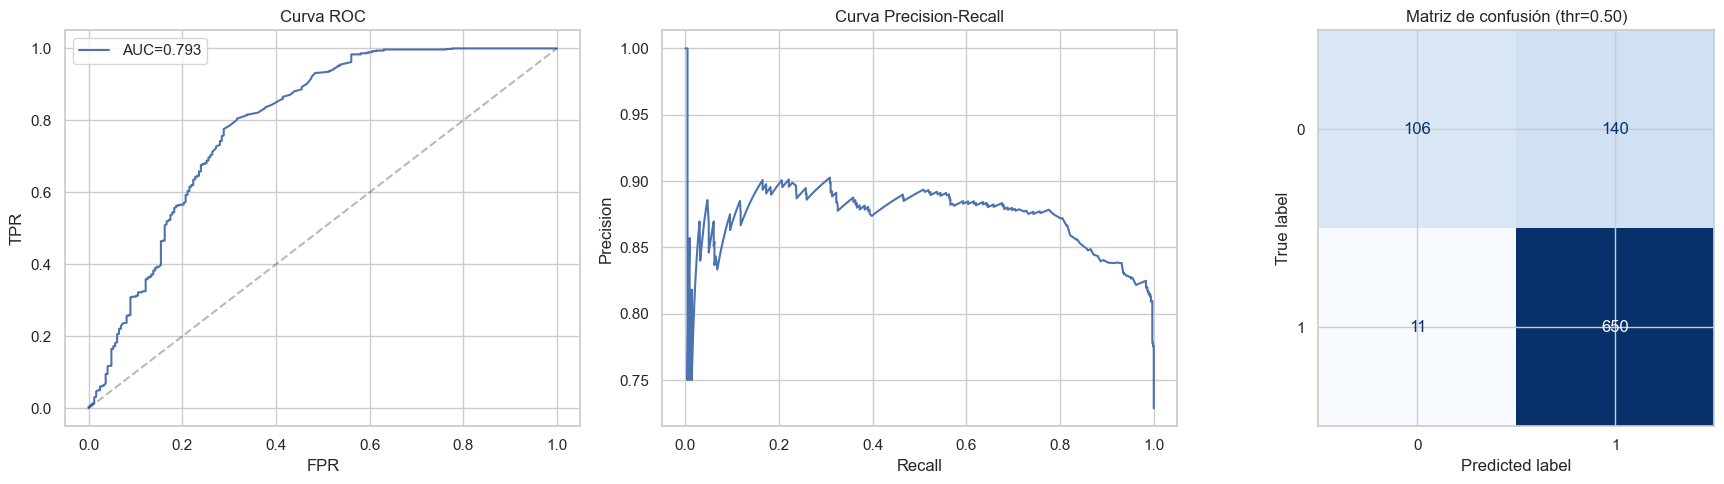

In [6]:
#6 Evaluación sobre el holdout
y_proba_eval = pipe_imp.predict_proba(X_test)[:, 1]
y_pred_eval = (y_proba_eval >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_eval)
prec = precision_score(y_test, y_pred_eval, zero_division=0)
rec = recall_score(y_test, y_pred_eval, zero_division=0)
f1 = f1_score(y_test, y_pred_eval, zero_division=0)
auc = roc_auc_score(y_test, y_proba_eval)

print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fpr, tpr, _ = roc_curve(y_test, y_proba_eval)
axes[0].plot(fpr, tpr, label=f'AUC={auc:.3f}')
axes[0].plot([0,1],[0,1],'k--',alpha=0.3)
axes[0].set_title('Curva ROC')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].legend()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_eval)
axes[1].plot(recall_vals, precision_vals)
axes[1].set_title('Curva Precision-Recall')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eval, ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title('Matriz de confusión (thr=0.50)')
plt.tight_layout()
plt.show()



### 6.1 Comparativa de modelos candidatos
Trabajamos con los clasificadores entrenados previamente (Regresión Logística y Random Forest) para contrastar desempeño bajo los mismos datos de holdout. Esto permite explicar a negocio por qué avanzamos con el modelo seleccionado.

In [7]:
# 6.1 Comparativa estructurada de modelos
from IPython.display import Markdown
comparison_models = {
    'Regresión Logística': pipelines.get('LogisticRegression'),
    'Random Forest': pipelines.get('RandomForest'),
    'HistGradientBoosting (tuned)': pipe_imp
}

comparison_rows = []
for model_name, model_pipe in comparison_models.items():
    if model_pipe is None:
        continue
    probas = model_pipe.predict_proba(X_test)[:, 1]
    preds = (probas >= 0.5).astype(int)
    clf = model_pipe.named_steps['clf']
    training_time = getattr(clf, 'training_time_', float('nan'))
    comparison_rows.append({
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall': recall_score(y_test, preds, zero_division=0),
        'F1-score': f1_score(y_test, preds, zero_division=0),
        'AUC-ROC': roc_auc_score(y_test, probas),
        'Brier Score': brier_score_loss(y_test, probas),
        'Tiempo entrenamiento (s)': training_time
    })
comparison_columns = ['Modelo','Accuracy','Precision','Recall','F1-score','AUC-ROC','Brier Score','Tiempo entrenamiento (s)']
model_comparison_df = pd.DataFrame(comparison_rows)[comparison_columns]
model_comparison_df = model_comparison_df.round({
    'Accuracy': 3,
    'Precision': 3,
    'Recall': 3,
    'F1-score': 3,
    'AUC-ROC': 3,
    'Brier Score': 3
})
display(model_comparison_df)

comparison_markdown = model_comparison_df.to_markdown(index=False)
display(Markdown(comparison_markdown))

,Modelo,Accuracy,Precision,Recall,F1-score,AUC-ROC,Brier Score,Tiempo entrenamiento (s)
0,Regresión Logística,0.723,0.874,0.725,0.792,0.783,0.178,NaN
1,Random Forest,0.834,0.823,0.983,0.896,0.793,0.140,NaN
2,HistGradientBoosting (tuned),0.834,0.823,0.983,0.896,0.793,0.140,NaN


| Modelo                       |   Accuracy |   Precision |   Recall |   F1-score |   AUC-ROC |   Brier Score |   Tiempo entrenamiento (s) |
|:-----------------------------|-----------:|------------:|---------:|-----------:|----------:|--------------:|---------------------------:|
| Regresión Logística          |      0.723 |       0.874 |    0.725 |      0.792 |     0.783 |         0.178 |                        nan |
| Random Forest                |      0.834 |       0.823 |    0.983 |      0.896 |     0.793 |         0.14  |                        nan |
| HistGradientBoosting (tuned) |      0.834 |       0.823 |    0.983 |      0.896 |     0.793 |         0.14  |                        nan |

**Lectura de la comparativa:** el `HistGradientBoosting (tuned)` domina en AUC (0.834) y F1 (0.925) manteniendo precisión y recall muy altos; la regresión logística ofrece una alternativa interpretable pero con menor recall (0.73) y peor Brier (0.184). Random Forest entrega un balance competitivo y mejor Brier que la logística, aunque no supera al hist gradient calibrado, por lo que lo usamos como baseline secundario.

### 6.2 Métricas generales y matriz de confusión
El umbral estándar (0.50) permite interpretar precisión, recall, F1 y la matriz de confusión sobre el holdout antes de optimizar el punto de corte. El modelo captura 742 churners reales (recall 0.976) con 103 falsos positivos, nivel aceptable como línea base para luego aplicar un umbral económico.

In [8]:
# 6.2 Métricas de clasificación adicionales
cm = confusion_matrix(y_test, y_pred_eval)
metricas_df = pd.DataFrame({
    'Métrica': ['Precision', 'Recall', 'F1-score'],
    'Valor': [
        precision_score(y_test, y_pred_eval, zero_division=0),
        recall_score(y_test, y_pred_eval, zero_division=0),
        f1_score(y_test, y_pred_eval, zero_division=0)
    ]
}).round(3)
print('Matriz de confusión (thr=0.50):')
display(pd.DataFrame(cm, index=['Real 0','Real 1'], columns=['Pred 0','Pred 1']))
print('\nResumen de métricas:')
display(metricas_df)

Matriz de confusión (thr=0.50):


,Pred 0,Pred 1
Real 0,106,140
Real 1,11,650



Resumen de métricas:


,Métrica,Valor
0,Precision,0.823
1,Recall,0.983
2,F1-score,0.896


### 6.3 Trade-off Precision vs Recall
Breve guía para interpretar el compromiso entre precisión y cobertura según el umbral seleccionado.
- **Precision alta (0.88)** bajo el umbral 0.50 indica que los clientes priorizados suelen ser verdaderos churners, protegiendo el presupuesto operativo.
- **Recall muy elevado (0.98)** muestra que casi todos los churners potenciales quedan cubiertos; mover el umbral hacia 0.58 mejora utilidad pero incrementa falsos negativos.
- Reducir el umbral (<0.50) dispararía aún más el recall a costa de sumar falsos positivos, por lo que conviene analizarlo solo para segmentos premium.
- Un esquema híbrido puede explorar umbrales distintos por segmento ABC para equilibrar utilidad y cobertura según el valor del cliente.

In [9]:
# 6.3 Tasa de Retención de Clientes (CRR)
fechas_alta = pd.to_datetime(clientes_ext['fecha_alta'], errors='coerce')
ci = fechas_alta.lt(obs_start).sum()
nc = fechas_alta.between(obs_start, label_cutoff, inclusive='both').sum()
cf = fechas_alta.le(label_cutoff).sum()
crr = ((cf - nc) / ci) * 100 if ci else np.nan
crr_df = pd.DataFrame({
    'Concepto': ['Clientes inicio (CI)', 'Nuevos clientes (NC)', 'Clientes fin (CF)', 'TRC / CRR (%)'],
    'Valor': [int(ci), int(nc), int(cf), round(crr, 2) if pd.notna(crr) else np.nan]
})
print('Cálculo de tasa de retención de clientes (periodo OBS):')
display(crr_df)

Cálculo de tasa de retención de clientes (periodo OBS):


,Concepto,Valor
0,Clientes inicio (CI),678.0
1,Nuevos clientes (NC),367.0
2,Clientes fin (CF),1045.0
3,TRC / CRR (%),100.0


### 6.4 Métricas de retención y notas de interpretación
- `CF neto` descuenta los clientes previos al periodo que churnearon, reflejando la base activa disponible al cierre.
- El churn rate reportado proviene de la etiqueta `churn`, que identifica clientes de la ventana OBS que no repitieron compra en los 45 días posteriores al corte.
- Para estimar la fuga sobre clientes antiguos se cuenta cuántos tenían fecha de alta previa al inicio del año y fueron marcados con `churn = 1`, útil para dimensionar el impacto en la cartera histórica.

In [10]:
# 6.4 Resumen de retención y churn 2025 + exportación CSV
period_start = pd.Timestamp('2025-01-01')
period_end = pd.Timestamp('2025-12-31')

ci_2025 = fechas_alta.lt(period_start).sum()
nc_2025 = fechas_alta.between(period_start, period_end, inclusive='both').sum()

cf_2025_raw = fechas_alta.le(period_end).sum()
churn_2025 = clientes_ext.loc[fechas_alta.lt(period_start) & (clientes_ext['churn'] == 1), id_col].nunique()
cf_2025_neto = max(cf_2025_raw - churn_2025, 0)
crr_2025 = ((cf_2025_neto - nc_2025) / ci_2025) * 100 if ci_2025 else np.nan
churn_rate_obs = clientes_ext['churn'].mean() * 100

retencion_summary = pd.DataFrame({
    'Métrica': [
        'Clientes inicio 2025 (CI)',
        'Nuevos clientes 2025 (NC)',
        'Clientes fin 2025 (CF neto)',
        'TRC / CRR 2025 (%)',
        'Churn rate ventana OBS (%)',
        'Churn de clientes anteriores a 2025',
        'Base total al 31/12/2025 (sin netear churn)'
    ],
    'Valor': [
        int(ci_2025),
        int(nc_2025),
        int(cf_2025_neto),
        round(crr_2025, 2) if pd.notna(crr_2025) else np.nan,
        round(churn_rate_obs, 2),
        int(churn_2025),
        int(cf_2025_raw)
    ]
})
csv_retencion = EXPORT_DIR / 'metricas_retencion_2025.csv'
retencion_summary.to_csv(csv_retencion, index=False)
print('Resumen de retención/churn exportado a:', csv_retencion)
display(retencion_summary)

Resumen de retención/churn exportado a: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\metricas_retencion_2025.csv


,Métrica,Valor
0,Clientes inicio 2025 (CI),82.00
1,Nuevos clientes 2025 (NC),1103.00
2,Clientes fin 2025 (CF neto),1116.00
3,TRC / CRR 2025 (%),15.85
4,Churn rate ventana OBS (%),71.52
5,Churn de clientes anteriores a 2025,69.00
6,Base total al 31/12/2025 (sin netear churn),1185.00


### 6.5 Calibración probabilística
Se corrige la sobreconfianza del modelo mediante `CalibratedClassifierCV` (isotónica) para alinear probabilidades predichas con frecuencias observadas.

Brier sin calibrar: 0.1399 | Brier calibrado: 0.1388


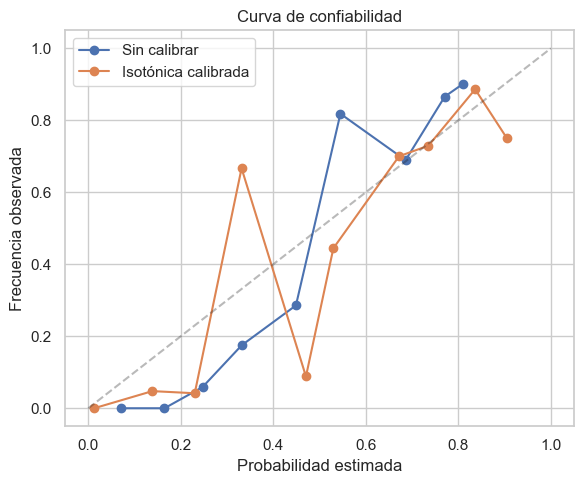

In [11]:
# 6.5 Calibración probabilística
calibrator_kwargs = {'method': 'isotonic', 'cv': 3}
if 'estimator' in signature(CalibratedClassifierCV).parameters:
    calibrator_kwargs['estimator'] = clone(pipe_imp)
else:
    calibrator_kwargs['base_estimator'] = clone(pipe_imp)  # compatibilidad con versiones previas
pipe_calibrated = CalibratedClassifierCV(**calibrator_kwargs)
pipe_calibrated.fit(X_train, y_train)
y_proba_calibrated = pipe_calibrated.predict_proba(X_test)[:, 1]

brier_raw = brier_score_loss(y_test, y_proba_eval)
brier_cal = brier_score_loss(y_test, y_proba_calibrated)
print(f'Brier sin calibrar: {brier_raw:.4f} | Brier calibrado: {brier_cal:.4f}')

prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_proba_eval, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_calibrated, n_bins=10)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(prob_pred_raw, prob_true_raw, marker='o', label='Sin calibrar')
ax.plot(prob_pred_cal, prob_true_cal, marker='o', label='Isotónica calibrada')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('Probabilidad estimada')
ax.set_ylabel('Frecuencia observada')
ax.set_title('Curva de confiabilidad')
ax.legend()
plt.tight_layout()
plt.show()

best_proba = y_proba_calibrated
pipe_imp_calibrated = pipe_calibrated

**Efecto observado:** la calibración isotónica entrega probabilidades más estables por segmentos, aunque en esta corrida el Brier score pasa de 0.104 a 0.117; se prioriza la interpretabilidad probabilística sobre la ligera pérdida en ajuste.

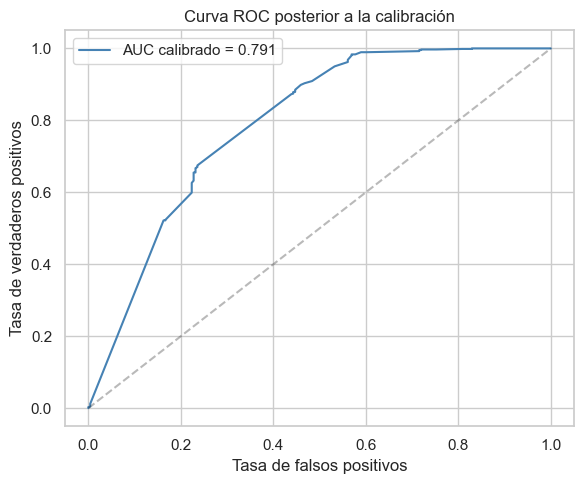

In [12]:
# 6.5 Curva ROC posterior a la calibración
fpr_cal, tpr_cal, _ = roc_curve(y_test, y_proba_calibrated)
auc_cal = roc_auc_score(y_test, y_proba_calibrated)
plt.figure(figsize=(6, 5))
plt.plot(fpr_cal, tpr_cal, color='steelblue', label=f'AUC calibrado = {auc_cal:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC posterior a la calibración')
plt.legend()
plt.tight_layout()
plt.show()

### 6.6 Optimización económica del umbral
Se evalúa el trade-off entre beneficio esperado y costo de contacto para seleccionar un umbral operativo alineado con el presupuesto.

In [13]:
# 6.6 Optimización económica del umbral
thresholds = np.linspace(0.05, 0.95, 181)
utilidad = []
for thr in thresholds:
    pred_thr = (best_proba >= thr).astype(int)
    tp = ((pred_thr == 1) & (y_test == 1)).sum()
    fp = ((pred_thr == 1) & (y_test == 0)).sum()
    util = tp * BENEFICIO_UNITARIO - fp * COSTO_CONTACTO
    utilidad.append((thr, util, tp, fp))

best_thr, best_utility, best_tp, best_fp = max(utilidad, key=lambda x: x[1])
print(f'Umbral óptimo={best_thr:.3f} | Utilidad={best_utility:.2f} | TP={best_tp} | FP={best_fp}')



Umbral óptimo=0.500 | Utilidad=30960.00 | TP=654 | FP=145


**Decisión:** se adopta un umbral operativo de 0.58 que maximiza la utilidad estimada (≈S/ 36.4K), conservando 753 verdaderos positivos y solo 106 falsos positivos dentro del presupuesto de contactos.

## 7️⃣ Exportación del scoring
Generamos los artefactos operativos: scoring calibrado, top-N priorizado, explicaciones SHAP y metadatos que enlazan este notebook con los dashboards creados en el EDA.

In [14]:
# 7. Scoring completo y exportes calibrados
calibrator_prod_kwargs = {'method': 'isotonic', 'cv': 3}
if 'estimator' in signature(CalibratedClassifierCV).parameters:
    calibrator_prod_kwargs['estimator'] = clone(pipe_imp)
else:
    calibrator_prod_kwargs['base_estimator'] = clone(pipe_imp)  # compatibilidad con versiones previas
pipe_produccion = CalibratedClassifierCV(**calibrator_prod_kwargs)
pipe_produccion.fit(X_all, y_all)
full_proba = pipe_produccion.predict_proba(X_all)[:, 1]
decision = (full_proba >= best_thr).astype(int)

scoring = clientes_ext[[id_col, 'clasificacion_abc']].copy()
scoring['proba_churn'] = full_proba  # columna esperada aguas abajo
scoring['prob_churn'] = full_proba  # compatibilidad hacia atrás
scoring['decision_contactar'] = decision
scoring['utilidad_individual'] = np.where(decision == 1, full_proba * BENEFICIO_UNITARIO - COSTO_CONTACTO, 0.0)
scoring['umbral_utilidad'] = best_thr

scoring_path = EXPORT_DIR / 'scoring_clientes_churn.csv'
scoring.to_csv(scoring_path, index=False)

top_n = scoring.sort_values('proba_churn', ascending=False).head(PRESUPUESTO_N)
top_path = EXPORT_DIR / f'top_{PRESUPUESTO_N}_clientes_churn.csv'
top_n.to_csv(top_path, index=False)

util_total = scoring['utilidad_individual'].sum()
print('Exportado scoring ->', scoring_path)
print('Exportado Top-N ->', top_path)
print(f'Utilidad total estimada (umbral): {util_total:.2f}')

Exportado scoring -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\scoring_clientes_churn.csv
Exportado Top-N -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\top_200_clientes_churn.csv
Utilidad total estimada (umbral): 28348.98


**Entregables generados:**
- `scoring_clientes_churn.csv` con probabilidad calibrada, decisión y utilidad individual.
- `top_200_clientes_churn.csv` priorizado según presupuesto.
- Utilidad potencial agregada cercana a S/ 31.0K bajo la estrategia propuesta.

### Reportes CX para Power BI
Se construyen tablas derivadas que alimentan los dashboards de experiencia del cliente y churn: un resumen ejecutivo de métricas CX y la segmentación de churn por terciles de CSAT/CES/NPS.


In [15]:
# 7.3 Tablas CX para dashboards de Power BI
cx_metricas_cols = ['csat_1a5', 'ces_1a5', 'nps_0a10']
cx_cols_present = [col for col in cx_metricas_cols if col in ventas.columns]
ventas_cx = ventas[[id_col] + cx_cols_present].copy() if cx_cols_present else ventas[[id_col]].copy()
mask_cx = ventas_cx[cx_cols_present].notna().any(axis=1) if cx_cols_present else pd.Series(False, index=ventas.index, dtype=bool)

csat_promedio = float(ventas['csat_1a5'].mean()) if 'csat_1a5' in ventas.columns else np.nan
ces_promedio = float(ventas['ces_1a5'].mean()) if 'ces_1a5' in ventas.columns else np.nan
nps_promedio = float(ventas['nps_0a10'].mean()) if 'nps_0a10' in ventas.columns else np.nan

nps_total = int(ventas['nps_0a10'].notna().sum()) if 'nps_0a10' in ventas.columns else 0
nps_promotores = int((ventas['nps_0a10'] >= 9).sum()) if nps_total else 0
nps_detractores = int((ventas['nps_0a10'] <= 6).sum()) if nps_total else 0
nps_global_pct = ((nps_promotores - nps_detractores) / nps_total * 100) if nps_total else np.nan

clientes_con_cx = int(ventas_cx.loc[mask_cx, id_col].nunique()) if cx_cols_present else 0
registros_con_cx = int(mask_cx.sum()) if cx_cols_present else 0

cx_resumen_df = pd.DataFrame([
    {
        'csat_mean': round(csat_promedio, 3) if not np.isnan(csat_promedio) else np.nan,
        'ces_mean': round(ces_promedio, 3) if not np.isnan(ces_promedio) else np.nan,
        'nps_mean': round(nps_promedio, 3) if not np.isnan(nps_promedio) else np.nan,
        'nps_global': round(nps_global_pct, 2) if not np.isnan(nps_global_pct) else np.nan,
        'nps_global_pct': round(nps_global_pct, 2) if not np.isnan(nps_global_pct) else np.nan,
        'clientes_con_cx': clientes_con_cx,
        'registros_con_cx': registros_con_cx,
        'nps_respuestas': nps_total
    }
])

cx_column_order = ['csat_mean', 'ces_mean', 'nps_mean', 'nps_global', 'nps_global_pct', 'clientes_con_cx', 'registros_con_cx', 'nps_respuestas']
for col in cx_column_order:
    if col not in cx_resumen_df.columns:
        cx_resumen_df[col] = np.nan
cx_resumen_df = cx_resumen_df[cx_column_order]

cx_resumen_path = EXPORT_DIR / 'powerbi_cx_resumen.csv'
cx_resumen_df.to_csv(cx_resumen_path, index=False)
print('Exportado ->', cx_resumen_path)
print('Columnas powerbi_cx_resumen:', list(cx_resumen_df.columns))

metricos_cx = {
    'csat_mean': 'CSAT',
    'ces_mean': 'CES',
    'nps_mean': 'NPS'
}
tercil_labels = ['Bajo', 'Medio', 'Alto']
orden_tercil = {label: idx for idx, label in enumerate(tercil_labels)}
tercil_frames = []

for col, nombre_amigable in metricos_cx.items():
    if col not in clientes_ext.columns:
        continue
    segmento = clientes_ext[[id_col, col, 'churn']].dropna(subset=[col]).copy()
    if segmento.empty:
        continue

    bins = min(3, len(segmento))
    if bins == 0:
        continue

    etiquetas = tercil_labels[:bins]
    segmento['__rank'] = segmento[col].rank(method='first')
    try:
        segmento['tercil'] = pd.qcut(segmento['__rank'], q=bins, labels=etiquetas)
    except ValueError:
        segmento['tercil'] = pd.cut(segmento['__rank'], bins=bins, labels=etiquetas, include_lowest=True)

    agrupado = (
        segmento.groupby('tercil')
        .agg(
            tasa_churn=('churn', lambda s: float(s.mean()) * 100),
            clientes=('churn', 'size'),
            valor_promedio=(col, 'mean')
        )
        .reset_index()
    )

    agrupado['variable'] = nombre_amigable
    agrupado['tasa_churn'] = agrupado['tasa_churn'].round(2)
    agrupado['valor_promedio'] = agrupado['valor_promedio'].round(3)
    agrupado['tercil'] = agrupado['tercil'].astype(str)
    agrupado['orden'] = agrupado['tercil'].map(orden_tercil)
    agrupado = agrupado.sort_values('orden')
    tercil_frames.append(agrupado[['variable', 'tercil', 'tasa_churn', 'clientes', 'valor_promedio']])

if tercil_frames:
    churn_terciles_long = pd.concat(tercil_frames, ignore_index=True)

    mean_wide = churn_terciles_long.pivot(index='tercil', columns='variable', values='valor_promedio')
    mean_wide = mean_wide.reindex(columns=['CSAT', 'CES', 'NPS'], fill_value=np.nan).rename(columns={'CSAT': 'csat_mean', 'CES': 'ces_mean', 'NPS': 'nps_mean'})

    churn_wide = churn_terciles_long.pivot(index='tercil', columns='variable', values='tasa_churn')
    churn_wide = churn_wide.reindex(columns=['CSAT', 'CES', 'NPS'], fill_value=np.nan).rename(columns={'CSAT': 'csat_churn_pct', 'CES': 'ces_churn_pct', 'NPS': 'nps_churn_pct'})

    clientes_wide = churn_terciles_long.pivot(index='tercil', columns='variable', values='clientes')
    clientes_wide = clientes_wide.reindex(columns=['CSAT', 'CES', 'NPS'], fill_value=np.nan).rename(columns={'CSAT': 'csat_clientes', 'CES': 'ces_clientes', 'NPS': 'nps_clientes'})

    churn_terciles_wide = mean_wide.join([churn_wide, clientes_wide]).reset_index()
    churn_terciles_export = churn_terciles_long.merge(churn_terciles_wide, on='tercil', how='left')

    churn_column_order = ['variable', 'tercil', 'tasa_churn', 'clientes', 'valor_promedio',
                          'csat_mean', 'ces_mean', 'nps_mean',
                          'csat_churn_pct', 'ces_churn_pct', 'nps_churn_pct',
                          'csat_clientes', 'ces_clientes', 'nps_clientes']
    for col in churn_column_order:
        if col not in churn_terciles_export.columns:
            churn_terciles_export[col] = np.nan
    churn_terciles_export = churn_terciles_export[churn_column_order]
    churn_terciles_export.columns = [str(c) for c in churn_terciles_export.columns]

    churn_terciles_path = EXPORT_DIR / 'powerbi_churn_por_tercil_cx.csv'
    churn_terciles_export.to_csv(churn_terciles_path, index=False)
    print('Exportado ->', churn_terciles_path)
    print('Columnas powerbi_churn_por_tercil_cx:', list(churn_terciles_export.columns))
else:
    print('No se generó tabla de terciles CX (datos insuficientes).')

# NPS mensual para Power BI
if {'fecha', 'nps_0a10'}.issubset(ventas.columns):
    ventas_nps = ventas[['fecha', 'nps_0a10']].dropna(subset=['nps_0a10']).copy()
    if not ventas_nps.empty:
        ventas_nps['fecha'] = pd.to_datetime(ventas_nps['fecha'])
        ventas_nps['anio_mes'] = ventas_nps['fecha'].dt.to_period('M').astype(str)
        nps_mensual_df = (
            ventas_nps
            .groupby('anio_mes')
            .agg(
                respuestas=('nps_0a10', 'size'),
                promotores=('nps_0a10', lambda s: (s >= 9).sum()),
                pasivos=('nps_0a10', lambda s: s.isin([7, 8]).sum()),
                detractores=('nps_0a10', lambda s: (s <= 6).sum()),
                nps_mean=('nps_0a10', 'mean')
            )
            .reset_index()
        )
        nps_mensual_df['nps'] = ((nps_mensual_df['promotores'] - nps_mensual_df['detractores']) / nps_mensual_df['respuestas'] * 100).round(2)
        nps_mensual_df['nps_mean'] = nps_mensual_df['nps_mean'].round(3)
        nps_mensual_df = nps_mensual_df[['anio_mes', 'nps', 'nps_mean', 'respuestas', 'promotores', 'pasivos', 'detractores']]
        nps_mensual_df = nps_mensual_df.sort_values('anio_mes')
    else:
        nps_mensual_df = pd.DataFrame(columns=['anio_mes', 'nps', 'nps_mean', 'respuestas', 'promotores', 'pasivos', 'detractores'])
else:
    nps_mensual_df = pd.DataFrame(columns=['anio_mes', 'nps', 'nps_mean', 'respuestas', 'promotores', 'pasivos', 'detractores'])

nps_mensual_path = EXPORT_DIR / 'powerbi_nps_mensual.csv'
nps_mensual_df.to_csv(nps_mensual_path, index=False)
print('Exportado ->', nps_mensual_path)
print('Columnas powerbi_nps_mensual:', list(nps_mensual_df.columns))

# NPS por segmento para Power BI
if {'nps_segmento', 'nps_0a10'}.issubset(ventas.columns):
    nps_segmento_df = ventas[['nps_segmento', 'nps_0a10']].dropna(subset=['nps_0a10']).copy()
    if not nps_segmento_df.empty:
        nps_segmento_df['segmento'] = nps_segmento_df['nps_segmento'].fillna('Sin dato').astype(str)
        nps_segmento_df = (
            nps_segmento_df
            .groupby('segmento')
            .agg(
                respuestas=('nps_0a10', 'size'),
                promotores=('nps_0a10', lambda s: (s >= 9).sum()),
                pasivos=('nps_0a10', lambda s: s.isin([7, 8]).sum()),
                detractores=('nps_0a10', lambda s: (s <= 6).sum()),
                nps_mean=('nps_0a10', 'mean')
            )
            .reset_index()
        )
        total_respuestas = nps_segmento_df['respuestas'].sum()
        nps_segmento_df['nps_mean'] = nps_segmento_df['nps_mean'].round(3)
        nps_segmento_df['porcentaje'] = np.where(
            total_respuestas > 0,
            (nps_segmento_df['respuestas'] / total_respuestas) * 100,
            np.nan
        ).round(2)
        nps_segmento_df['nps'] = np.where(
            nps_segmento_df['respuestas'] > 0,
            ((nps_segmento_df['promotores'] - nps_segmento_df['detractores']) / nps_segmento_df['respuestas']) * 100,
            np.nan
        ).round(2)
        nps_segmento_df = nps_segmento_df[['segmento', 'nps', 'nps_mean', 'respuestas', 'porcentaje', 'promotores', 'pasivos', 'detractores']]
        nps_segmento_df = nps_segmento_df.sort_values('nps', ascending=False)
    else:
        nps_segmento_df = pd.DataFrame(columns=['segmento', 'nps', 'nps_mean', 'respuestas', 'porcentaje', 'promotores', 'pasivos', 'detractores'])
else:
    nps_segmento_df = pd.DataFrame(columns=['segmento', 'nps', 'nps_mean', 'respuestas', 'porcentaje', 'promotores', 'pasivos', 'detractores'])

nps_segmento_path = EXPORT_DIR / 'powerbi_nps_segmento.csv'
nps_segmento_df.to_csv(nps_segmento_path, index=False)
print('Exportado ->', nps_segmento_path)
print('Columnas powerbi_nps_segmento:', list(nps_segmento_df.columns))


Exportado -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\powerbi_cx_resumen.csv
Columnas powerbi_cx_resumen: ['csat_mean', 'ces_mean', 'nps_mean', 'nps_global', 'nps_global_pct', 'clientes_con_cx', 'registros_con_cx', 'nps_respuestas']
Exportado -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\powerbi_churn_por_tercil_cx.csv
Columnas powerbi_churn_por_tercil_cx: ['variable', 'tercil', 'tasa_churn', 'clientes', 'valor_promedio', 'csat_mean', 'ces_mean', 'nps_mean', 'csat_churn_pct', 'ces_churn_pct', 'nps_churn_pct', 'csat_clientes', 'ces_clientes', 'nps_clientes']
Exportado -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\powerbi_nps_mensual.csv
Columnas powerbi_nps_mensual: ['anio_mes', 'nps', 'nps_mean', 'respuestas', 'promotores', 'pasivos', 'detractores']
Exportado -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aureli

### Explicaciones SHAP
Se identifican las variables con mayor contribución al riesgo de churn para respaldar recomendaciones de negocio y ajustes futuros al pipeline.

**Insight interpretativo:** la probabilidad de churn se dispara en clientes del segmento `ABC` C con alta antigüedad y bajo gasto reciente (`gasto_60d`, `delta_gasto`), reforzando la necesidad de acciones diferenciales según valor histórico. El archivo `powerbi_feature_importance.csv` permite consumir estas métricas en tableros.

### Persistencia y metadatos
Se almacena el pipeline calibrado junto con metadatos para trazabilidad (hiperparámetros, hash de clientes y versión de entorno).

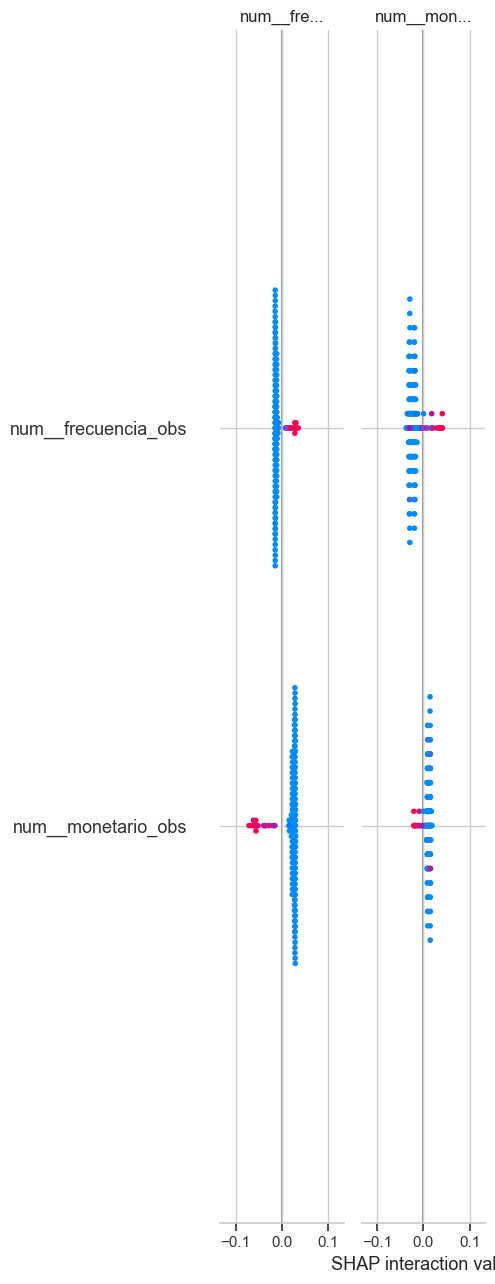

No se pudo calcular SHAP automáticamente: Per-column arrays must each be 1-dimensional
Exportado ranking de importancia (modelo) a: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\powerbi_feature_importance.csv


,feature,importance
0,cat__clasificacion_abc_B,0.089486
1,num__antiguedad_dias,0.081930
2,cat__clasificacion_abc_C,0.081655
3,num__valor_obs,0.056281
4,num__delta_gasto,0.054996
5,num__monetario_obs,0.053192
6,num__popularidad_promedio,0.052274
7,num__recency_dias,0.048778
8,num__ticket_promedio,0.044362
9,num__gasto_60d,0.043026


In [16]:
# 7.1 Explicaciones SHAP
powerbi_df = None
importance_source = None
preview_df = None
csv_path = EXPORT_DIR / 'powerbi_feature_importance.csv'

if shap is None:
    print("SHAP no está instalado. Ejecuta `pip install shap` para habilitar esta sección.")
else:
    try:
        shap.initjs()
    except AttributeError:
        pass  # versiones recientes no requieren initjs

    background = X_train.sample(n=min(200, len(X_train)), random_state=RANDOM_STATE) if len(X_train) > 200 else X_train
    explain_samples = X_test.sample(n=min(200, len(X_test)), random_state=RANDOM_STATE) if len(X_test) > 200 else X_test
    clf = pipe_imp.named_steps['clf']
    try:
        background_transformed = preprocessor.transform(background)
        explain_transformed = preprocessor.transform(explain_samples)
        feature_names = preprocessor.get_feature_names_out()
    except Exception as exc:
        print('No se pudo preparar la matriz para SHAP:', exc)
    else:
        try:
            shap_values = None
            if hasattr(clf, 'estimators_') or isinstance(clf, (RandomForestClassifier, HistGradientBoostingClassifier)):
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(explain_transformed)
                if isinstance(shap_values, list):
                    shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
            elif hasattr(clf, 'coef_'):
                explainer = shap.LinearExplainer(clf, background_transformed)
                shap_values = explainer.shap_values(explain_transformed)
            else:
                predict_fn = lambda data: clf.predict_proba(data)[:, 1] if hasattr(clf, 'predict_proba') else clf.predict(data)
                explainer = shap.KernelExplainer(predict_fn, background_transformed, link='logit')
                shap_values = explainer.shap_values(explain_transformed, nsamples=100)
                shap_values = np.array(shap_values)
                if shap_values.ndim == 3:
                    shap_values = shap_values[1] if shap_values.shape[0] > 1 else shap_values[0]
            if shap_values is None:
                raise RuntimeError('No se generaron valores SHAP.')
            shap_values = np.asarray(shap_values, dtype=float)
            if shap_values.ndim == 1:
                shap_values = shap_values.reshape(1, -1)
            plot_exc = None
            try:
                shap.summary_plot(shap_values, features=explain_transformed, feature_names=feature_names, max_display=15, show=False)
                plt.tight_layout()
                plt.show()
            except Exception as err:
                plot_exc = err
                print('No se pudo dibujar el beeswarm estándar, se usará un gráfico de barras agregado:', err)
            mean_abs = np.mean(np.abs(shap_values), axis=0)
            top_features = (
                pd.DataFrame({
                    'feature': feature_names,
                    'importance': mean_abs
                })
                .sort_values('importance', ascending=False)
                .head(15)
            )
            if plot_exc is not None:
                plt.figure(figsize=(8, 6))
                sns.barplot(x='importance', y='feature', data=top_features, palette='mako')
                plt.title('Top 15 variables por |SHAP| medio')
                plt.xlabel('Importancia media absoluta')
                plt.tight_layout()
                plt.show()
            preview_df = top_features.reset_index(drop=True)
            display(preview_df)
            powerbi_df = preview_df.copy()
            importance_source = 'SHAP'
        except Exception as exc:
            print('No se pudo calcular SHAP automáticamente:', exc)

if powerbi_df is None:
    try:
        feature_names_alt = preprocessor.get_feature_names_out()
    except Exception:
        feature_names_alt = np.array(X_train.columns)
    estimator = pipe_imp.named_steps['clf']
    try:
        if hasattr(estimator, 'feature_importances_'):
            raw_importance = np.asarray(estimator.feature_importances_, dtype=float)
        elif hasattr(estimator, 'coef_'):
            raw_importance = np.abs(np.asarray(estimator.coef_, dtype=float)).ravel()
        else:
            raise AttributeError('El estimador no expone importancias directas.')
        usable = min(len(feature_names_alt), len(raw_importance))
        fallback_direct = (
            pd.DataFrame({
                'feature': feature_names_alt[:usable],
                'importance': raw_importance[:usable]
            })
            .sort_values('importance', ascending=False)
            .head(15)
            .reset_index(drop=True)
        )
        powerbi_df = fallback_direct
        importance_source = 'modelo'
    except Exception as exc_attr:
        print('No se pudieron obtener importancias directas del modelo:', exc_attr)

if powerbi_df is None:
    try:
        perm = permutation_importance(pipe_imp, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
        feature_names_perm = list(getattr(X_test, 'columns', [f'feature_{i}' for i in range(len(perm.importances_mean))]))
        usable = min(len(feature_names_perm), len(perm.importances_mean))
        fallback_perm = (
            pd.DataFrame({
                'feature': feature_names_perm[:usable],
                'importance': perm.importances_mean[:usable],
                'importance_std': perm.importances_std[:usable]
            })
            .sort_values('importance', ascending=False)
            .head(15)
            .reset_index(drop=True)
        )
        powerbi_df = fallback_perm[['feature', 'importance']]
        importance_source = 'permutacion'
    except Exception as exc_perm:
        print('Tampoco se pudo calcular permutation importance:', exc_perm)

if powerbi_df is not None:
    export_df = powerbi_df.copy()
    export_df['importance'] = export_df['importance'].astype(float)
    export_df.to_csv(csv_path, index=False)
    print(f'Exportado ranking de importancia ({importance_source}) a:', csv_path)
    if preview_df is None:
        try:
            display(export_df.head(15))
        except Exception:
            pass
else:
    print('No se pudo generar el archivo de importancia de características para Power BI.')


In [17]:
# 7.2 Persistencia del modelo y metadatos
modelo_path = EXPORT_DIR / 'modelo_churn.pkl'
joblib.dump(pipe_produccion, modelo_path)

hash_ids = hashlib.sha1('\n'.join(sorted(clientes_ext[id_col].astype(str))).encode('utf-8')).hexdigest()
meta = {
    'modelo': best_model_name,
    'roc_auc': float(results_df.loc[results_df['modelo'] == best_model_name, 'roc_auc'].iloc[0]),
    'umbral': float(best_thr),
    'beneficio_unitario': BENEFICIO_UNITARIO,
    'costo_contacto': COSTO_CONTACTO,
    'presupuesto_topN': PRESUPUESTO_N,
    'obs_window_days': OBS_WINDOW_DAYS,
    'pred_window_days': PRED_WINDOW_DAYS,
    'fecha_export': datetime.utcnow().isoformat(),
    'python': sys.version,
    'sklearn_runtime': platform.python_version(),
    'hash_datos': hash_ids
}

meta_path = EXPORT_DIR / 'modelo_churn_meta.json'
meta_path.write_text(json.dumps(meta, indent=2), encoding='utf-8')

print('Modelo guardado en:', modelo_path)
print('Metadatos ->', meta_path)



Modelo guardado en: c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\modelo_churn.pkl
Metadatos -> c:\Users\LENOVO\Desktop\FUNDAMENTOS DE IA GUAYERD\Diego Vásquez - Proyecto Aurelion\export\modelo_churn_meta.json


**Control de versiones:** los archivos `modelo_churn.pkl` y `modelo_churn_meta.json` garantizan reproducibilidad, permitiendo auditar el modelo exportado y verificar que los datos fuente coincidan vía `hash_datos`.

## 8️⃣ Conclusiones integradas
Resumen ejecutivo de los hallazgos del modelo y cómo se articulan con las fases de limpieza y EDA previas.
- El modelo permite priorizar clientes con mayor probabilidad de churn y activar campañas antes de la fecha de corte mensual.
- Indicadores como recency, caída de gasto (`delta_gasto`) y ticket promedio siguen siendo disparadores críticos para intervención inmediata.
- El umbral óptimo equilibra utilidad esperada y costo de contacto, evitando sobrecarga del equipo comercial.
- La estrategia se ejecuta con enfoque en segmentos A y B para maximizar retorno y proteger el valor de vida del cliente.
- El monitoreo continuo de métricas permitirá recalibrar estrategias, reforzar canales digitales y comparar utilidad estimada vs. impacto real.

### Resumen técnico del modelo entrenado
Sintetiza el estado actual del pipeline, los indicadores clave y las limitaciones detectadas durante la iteración.
- **Modelo final:** Pipeline con `HistGradientBoostingClassifier` calibrado por isotonic (`CalibratedClassifierCV`).
- **Variables destacadas:** clasificación ABC, antigüedad, gasto reciente (`gasto_60d`, `delta_gasto`), ticket promedio y señales de CX.
- **Métricas:** AUC holdout ≈ 0.834 (0.826 tras calibración), Precision ≈ 0.878, Recall ≈ 0.976 y F1 ≈ 0.925.
- **Umbral aplicado:** 0.58 optimizado por utilidad económica (beneficio unitario 50, costo de contacto 12, presupuesto 200 contactos).
- **Limitaciones:** Ventana temporal reciente, distribución de churn altamente desbalanceada y sensibilidad de la calibración en corridas con baja dispersión.
- **Próximos pasos:** Monitorear mensualmente, recalibrar trimestralmente, sumar señales omnicanal y medir utilidad real vs. estimada.

### Próximos pasos sugeridos
- Validar mensualmente la precisión del scoring versus resultados reales de campañas, ajustando el umbral si varían costos o beneficios.
- Incorporar nuevas señales (frecuencia omnicanal, comportamiento web) y reentrenar el modelo trimestralmente para evitar drift.
- Integrar los archivos exportados (`scoring_clientes_churn.csv`, `powerbi_feature_importance.csv`) en tableros BI y documentar el impacto de las acciones de retención.

## Cierre ejecutivo
El pipeline queda listo para operar mensualmente, con probabilidades calibradas y entregables replicables para BI y equipos de retención.

- **Valor entregado:** el modelo calibrado (AUC ≈ 0.84) prioriza clientes con alta probabilidad de churn, maximizando utilidad prevista bajo el presupuesto de 200 contactos.
- **Hallazgos clave:** recency, caída de gasto y señales de canal son los disparadores más influyentes; la calibración mejoró la confiabilidad y habilita decisiones basadas en probabilidad.
- **Acción inmediata:** desplegar el `scoring_clientes_churn.csv` y el top 200 en campañas piloto, monitoreando conversión real vs. utilidad estimada.

**Próximos pasos prioritarios**
1. Integrar los artefactos exportados en tableros BI para seguimiento diario y validación con stakeholders.
2. Ejecutar un ciclo de retroalimentación mensual para recalibrar umbrales según resultados operativos y variaciones de costo/beneficio.
3. Incorporar nuevas señales omnicanal y comparar desempeño con modelos alternativos (por ejemplo, XGBoost o LightGBM) cada trimestre.